# Practical 7: Clustering

### In this practical
1. [Preparing data for clustering](#prep)
2. [Building the K-means clustering](#clustering)
3. [Understanding and visualising a clustering model](#viz)

---
**Written by Richi Nayak (r.nayak@qut.edu.au). All rights reserved.**

This practical introduces you to clustering using Python. You will learn how to preprocess data for clustering, building clustering solutions and evaluate/visualise the results. Different from the algorithms/models introduced in the first half of the semester, the dataset used for clustering is **unlabelled**. This dataset do not have the label information that is mandatory in predictive data mining. 


## 1. Preparing data for clustering<a name="prep"></a>

We will be using the `Census2000` dataset, which contains the postal code-level summary of the 2000 United States Census. There are 7 variables in this dataset:
* `ID`: Postal code of the region
* `LOCX`: Region longitude
* `LOCY`: Region latitude
* `MEANHHSZ`: Average household size in the region
* `MEDHHINC`: Median household income in the region
* `REGDENS`: Region population density percentile (1=lowest density, 100 = highest density)
* `REGPOP`: Number of people in the region

There is no target known in this data therefore we will utilize unsupervised
learning method, clustering, to analyse this data. The goal of the analysis is
to group people into distinct subsets based on urbanization, household size, and income factors. These factors are common to matching commercial life-style and life-stage segmentation products (for example, see www.claritas.com or
www.spectramarketing.com).

Similar with past practicals, we will use `pandas` to load the data and perform data preprocessing.

In [1]:
import pandas as pd
import numpy as np

# not skipping empty values, to demonstrate data preprocessing steps later
df = pd.read_csv('census2000.csv', na_filter=False)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33178 entries, 0 to 33177
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ID        33178 non-null  object 
 1   LocX      33178 non-null  float64
 2   LocY      33178 non-null  float64
 3   RegDens   33178 non-null  object 
 4   RegPop    33178 non-null  int64  
 5   MedHHInc  33178 non-null  int64  
 6   MeanHHSz  33178 non-null  float64
dtypes: float64(3), int64(2), object(2)
memory usage: 1.8+ MB


From the `.info()` output, you should notice the `RegDens` variable type is set incorrectly. The output listed `RegDens` as object/categorical, while based on the dataset description given above, `RegDens` should be an interval/numerical variable. Run `.describe()` and `.value_counts()` on the Series to get more information.

In [2]:
# get more information from RegDens
print(df['RegDens'].describe())
print(df['RegDens'].value_counts())

count     33178
unique      101
top            
freq       1013
Name: RegDens, dtype: object
      1013
11     322
75     322
70     322
40     322
      ... 
74     321
56     321
12     321
18     321
6      321
Name: RegDens, Length: 101, dtype: int64


The output of these functions reveals the cause of the incorrect type, which is a number of empty strings in this Series. Replace them with `nan` to denote them as missing values and typecast the series into float data type.

In [3]:
# replace the empty strings in the series with nan and typecast to float
df['RegDens'] = df['RegDens'].replace('', np.nan).astype(float)

As we learned from week 2, visualisation is a great way to spot data problems within the dataset. Again, we will use `seaborn` and `matplotlib` for that purpose. Plot the distribution of the variables using `distplot`.

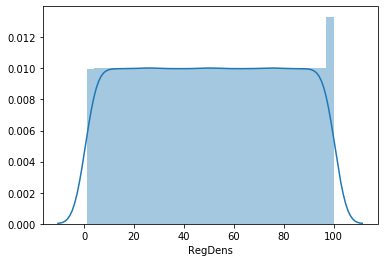

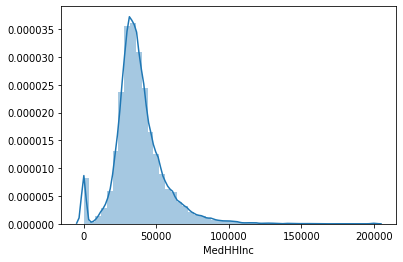

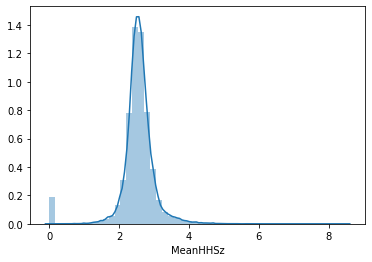

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
# Distribution of RegDens
regdens_dist = sns.distplot(df['RegDens'].dropna())
plt.show()

# Distribution of MedHHInc
medhhinc_dist = sns.distplot(df['MedHHInc'].dropna())
plt.show()

# Distribution of MeanHHSz
meanhhsz_dist = sns.distplot(df['MeanHHSz'].dropna())

plt.show()

The last two distplots show anomalies in `MeanHHSz` and `MedHHInc`. For both of these variables, there is a large number of very low valued entries. Focus on `MeanHHSz` first. "Zoom in" on the distribution plot by increasing the number of bins.

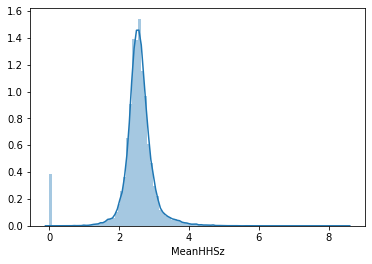

In [5]:
# Distribution of MeanHHSz, with increased number of bins. More bins = more specific distplot.
meanhhsz_dist = sns.distplot(df['MeanHHSz'].dropna(), bins=100)
plt.show()

It is apparent that many of the records are valued close to zero, and logically it is unlikely for an household to have less than 1 member (need more than 1 persons in a household). This suggests a data problem with this variable. As mentioned before, `MedHHInc` also contains some errorneous values. There is a chance that these anomalies are related. We could explore this relation using FaceTGrid.

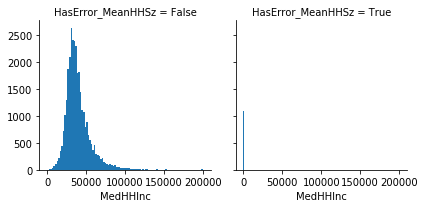

In [6]:
# create a mask of errorneous MeanHHSz values
df['HasError_MeanHHSz'] = df['MeanHHSz'] < 1

# use FaceTGrid to plot the distribution of MedHHInc when MeanHHSZ is errorneous
g = sns.FacetGrid(df, col='HasError_MeanHHSz')
g = g.map(plt.hist, 'MedHHInc', bins=100)

plt.show()

FacetGrid shows that errorneous data in `MeanHHSz` are correlated with errorneous data in `MedHHInc`. Based on this insight, we should eliminate all rows with errorneous `MeanHHSz`.

In [7]:
# before
print("Row # before dropping errorneous rows", len(df))

# a very easy way to drop rows with MeanHHSz values below 1
df = df[df['MeanHHSz'] >= 1]

# after
print("Row # after dropping errorneous rows", len(df))

Row # before dropping errorneous rows 33178
Row # after dropping errorneous rows 32079


Plot all three variables for final check.

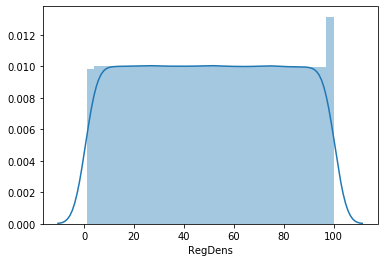

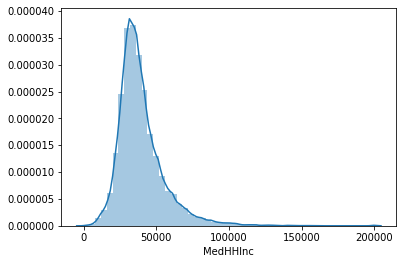

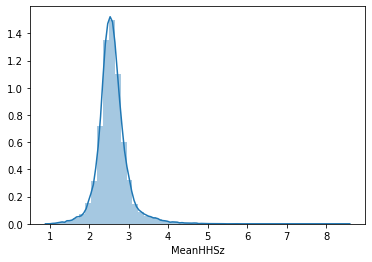

In [8]:
# Distribution of RegDens
regdens_dist = sns.distplot(df['RegDens'].dropna())
plt.show()

# Distribution of MedHHInc
medhhinc_dist = sns.distplot(df['MedHHInc'].dropna())
plt.show()

# Distribution of MeanHHSz
meanhhsz_dist = sns.distplot(df['MeanHHSz'].dropna())

plt.show()

## 2. Building the first K-means clustering<a name="clustering"></a>

Once the data is cleaned, we are ready to build a clustering model. Before
building the model, we should set the objective of this clustering process.
There are a number of good grouping objectives to be applied on this dataset.
The suburbs can be clustered based on location (`LocX` and `LocY`), demographic characteristic (`RegDens`, `MedHHInc`, `MeanHHSz` and `RegPop`) or both. As clustering suburbs based on geographical location is quite straightforward, we will focus on clustering based on demographic characteristics in this practical. Moreover, as in predictive mining, we do not use *ID-like variables whose values are unique for each record such as* `LocX` and `LocY`*. These fields do not add any values to data mining process.*

Thus, we will use `MedHHInc`, `MeanHHSz` and `RegDens` and drop the rest of the features. We will also drop `RegPop` as it is redundant with `RegDens`. `RegPop` is also highly influenced by suburb area size, an information we do not have in this dataset. To compare regions based on their demographic information accurately, `RegDens` is more suitable.

Similar with regression and neural network, clustering is also sensitive to inputs on different scale. Recall from the lecture that clustering uses **proximity/distance measure**. The most common distance measure is **Euclidian distance**. With inputs on different scale, Euclidian distance favors features on larger scale. Thus, we need to apply scaling before performing clustering.

In [9]:
from sklearn.preprocessing import StandardScaler

# take 3 variables and drop the rest
df2 = df[['MedHHInc', 'MeanHHSz', 'RegDens']]

# convert df2 to matrix
X = df2.values

# scaling
scaler = StandardScaler()
X = scaler.fit_transform(X)

`sklearn` has many clustering solution implemented. In this practical, we will focus on the most common clustering, **K-Means**. As explained in the lecture, K-means starts by picking $k$ random points as the initial cluster centers (centroids). For each iteration of K-means, all data points are assigned to the closest centroids. Each centroids are then updated to get closer to the mean of each cluster.

In your project space/iPython console, start by importing the K-Means clustering. Initialise the clustering with `n_clusters` hyperparameter ($K$) of 3 and fit it to the dataset given. Similar as many data mining models, K-Means clustering has the element of randomness, which is controlled by the `random_state` hyperparameter.

Remember, in clustering, we want to minimize the intra-cluster distance while maximizing the inter-cluster distances. After the model is fitted, print out its `inertia` (sum of distances of samples to their closest cluster center/centroid) and centroid locations.

In [10]:
from sklearn.cluster import KMeans

# random state, we will use 42 instead of 10 for a change
rs = 42

# set the random state. different random state seeds might result in different centroids locations
model = KMeans(n_clusters=3, random_state=rs)
model.fit(X)

# sum of intra-cluster distances
print("Sum of intra-cluster distance:", model.inertia_)

print("Centroid locations:")
for centroid in model.cluster_centers_:
    print(centroid)

Sum of intra-cluster distance: 52450.590197153564
Centroid locations:
[1.31801745 0.91730431 0.75459506]
[-0.41317147 -0.08392096 -0.88327097]
[-0.17519304 -0.41742819  0.83816619]


The number of clusters is controlled by the `n_clusters` hyperparameter. Setting the k-value is a subjective process due to the absence of the label information. It usually depends upon the domain information whether a small or high number of clusters required for data understanding. Or it can be a trial and error process. We explain later a systematic process to set the k value. A higher $K$ will result in more centroids and clusters, which typically results in lower inertia and a finer-grained cluster solution. However it may not be an indication of right solution as avery high value of $K$ can create many small meaningless clusters.

In [11]:
# set a different n_clusters
model = KMeans(n_clusters=8, random_state=rs)
model.fit(X)

# sum of intra-cluster distances
print("Sum of intra-cluster distance:", model.inertia_)

print("Centroid locations:")
for centroid in model.cluster_centers_:
    print(centroid)

Sum of intra-cluster distance: 27714.36231225028
Centroid locations:
[-0.27454857 -0.1577295  -0.00554968]
[1.11461835 0.31026514 0.77228009]
[-0.19642367 -1.05685288  1.14381746]
[-0.43545227  0.68390749  1.13766219]
[-0.23679633  0.51857153 -0.9360597 ]
[-0.3157633   3.24487675  0.14829235]
[3.42065995 0.55990691 0.97283184]
[-0.5722583  -0.68466511 -1.1917228 ]


### 2.1. Agglomerative Clustering

As an alternative to K-means clustering which uses centroid-based approach, agglomerative/hierarchical clustering is also commonly used to perform clustering on dataset. As discussed in the lecture, agglomerative clustering starts from bottom and assigns each data point as its own cluster. For each pair of clusters, agglomerative clustering recursively merges the pair of clusters, minimising linkage distance between each cluster.

Similar to KMeans, you need to import the agglomerative clustering algorithm from `sklearn.cluster` module.

In [12]:
from sklearn.cluster import AgglomerativeClustering

Once the model is imported, you can train a model using the following code. You also need to specify `K` or the number of clusters. Here, we will use `K = 3`. For visualisation purpose (later in this section), we will only train this model on 50 data points, but agglomerative clustering can handle many data points just fine.

In [13]:
agg_model = AgglomerativeClustering(n_clusters=3)
agg_model.fit(X[:50]) # subset of X, only 50 data points

AgglomerativeClustering(n_clusters=3)

Once the training is finished, you could visualise the dendrogram of this model using the following code.

In [14]:
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    # Children of hierarchical clustering
    children = model.children_

    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])

    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0]+2)

    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

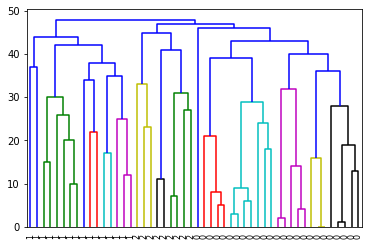

In [15]:
plot_dendrogram(agg_model, labels=agg_model.labels_)
plt.show()

Cluster labels are presented on the X axis, with the last `K=3` joins on the top of the tree being the cluster centroids.

You can explore more about agglomerative clustering on your own time. This tutorial notes will use **KMeans** model for the subsequent sections.

## 3. Understanding and Visualising a Clustering Model<a name="viz"></a>

We will take a closer look into the generated clustering model. A common method to understand clustering results is to visualise the distribution of variables in clusters. We have done this in a very limited way by printing the values of centroids.

To gain a better view on how the clusters are spread out in the dataset, we can use seaborn's pairplot. Before that, we will use the generated clustering model to assign each record in the dataset with a cluster ID.

Cluster membership
1    15319
2    10575
0     6185
Name: Cluster_ID, dtype: int64


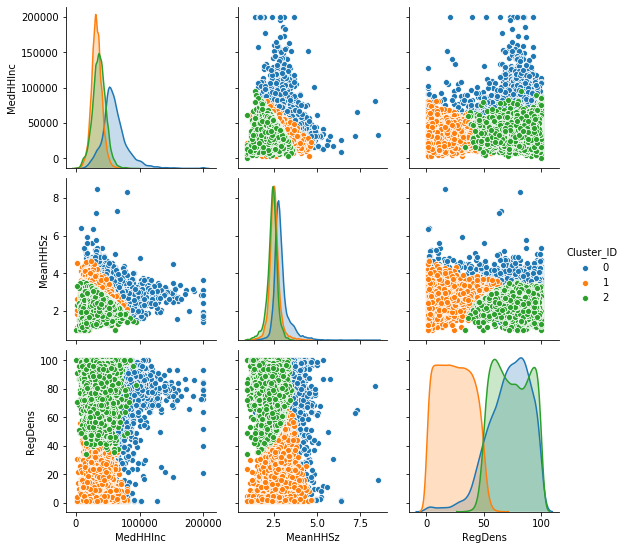

In [16]:
model = KMeans(n_clusters=3, random_state=rs).fit(X)

# assign cluster ID to each record in X
# Ignore the warning, does not apply to our case here
y = model.predict(X)
df2['Cluster_ID'] = y

# how many records are in each cluster
print("Cluster membership")
print(df2['Cluster_ID'].value_counts())

# pairplot the cluster distribution.
cluster_g = sns.pairplot(df2, hue='Cluster_ID')
plt.show()

**Your clustering plots should look similar, but the cluster ID might not be
similar. That is totally fine, not something that you can control even with
`random_state`**. This relates to the fact, discussed in the lecture, that k-means clustering algorithm yields a local solution and every run may generate a different solution.

The pairplot shows us how different cluster members have different value
distribution on different variables. Here is how to interpret the plots:

1. Take `MeanHHSz` distribution for example (second row, fourth column). Suburbs in cluster 0 are generally suburbs with average large households, while cluster 1 and 2 have the smaller ones.
2. Look at `MeanHHSz` and `RegDens` plot (second row, third column) and we could see the difference between suburbs in cluster 1 and 2. Cluster 1 covers less densely populated suburbs with smaller households, while cluster 2 covers more crowded regions and still small families.
3. For `MedHHInc` (first row, second column), pairplot shows that cluster 0 covering regions with higher median household.

The visualisation helps us to profile the clusters as follow:
* Cluster 0: Suburbs with large households and medium-high earnings.
* Cluster 1: Sparse populated suburbs with smaller, low earning households.
* Cluster 2: Dense populated suburbs with smaller, low earning households.

While this PairPlot is useful to provide overall cluster profiles, it can get very cluttered and hard to understand if there are more clusters. In addition, you might only want to understand a specific cluster, therefore a PairPlot with all clusters might not be necessary.

Consider the following clustering model with $K = 8$.

In [17]:
# set a different n_clusters
model = KMeans(n_clusters=8, random_state=rs)
model.fit(X)

# sum of intra-cluster distances
print("Sum of intra-cluster distance:", model.inertia_)

print("Centroid locations:")
for centroid in model.cluster_centers_:
    print(centroid)

Sum of intra-cluster distance: 27714.362312250287
Centroid locations:
[-0.27454857 -0.1577295  -0.00554968]
[1.11461835 0.31026514 0.77228009]
[-0.19642367 -1.05685288  1.14381746]
[-0.43545227  0.68390749  1.13766219]
[-0.23679633  0.51857153 -0.9360597 ]
[-0.3157633   3.24487675  0.14829235]
[3.42065995 0.55990691 0.97283184]
[-0.5722583  -0.68466511 -1.1917228 ]


Cluster membership
0    7356
7    6227
4    5155
1    4890
2    3986
3    2462
6    1026
5     977
Name: Cluster_ID, dtype: int64


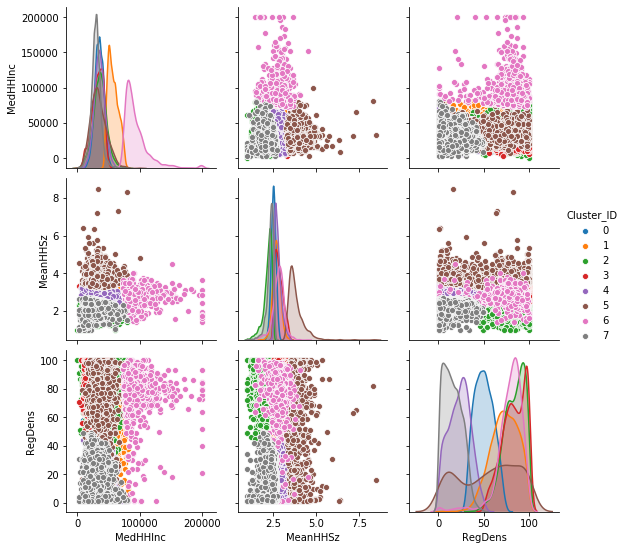

In [18]:
# again, ignore the warning
y = model.predict(X)
df2['Cluster_ID'] = y

# how many in each
print("Cluster membership")
print(df2['Cluster_ID'].value_counts())

# pairplot
cluster_g = sns.pairplot(df2, hue='Cluster_ID')
plt.show()

As the number of clusters increases, the PairPlot becomes more specific, and more confusing and difficult to interpret.

Assume you would like to get insights on cluster 0 and 1 from our $K=8$ K-Means clustering. An alternative way to profile them is to plot their respective variable distributions against the distributions from all data. This method shows certain characteristics of a cluster compared to characteristics of the whole dataset. Similar to practical 2, we will use `distplot` to visualise variable distribution. Use the following code:

Distribution for cluster 0


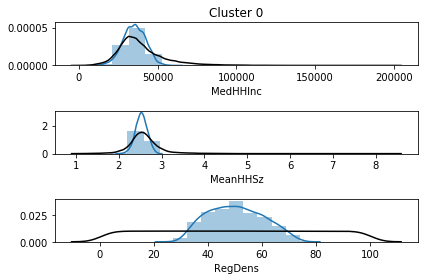

Distribution for cluster 1


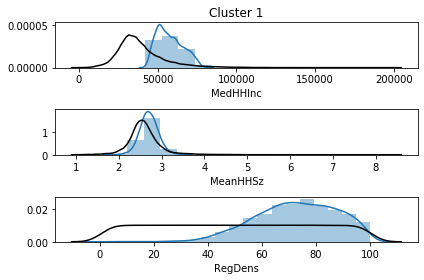

In [19]:
# prepare the column and bin size. Increase bin size to be more specific, but 20 is more than enough
cols = ['MedHHInc', 'MeanHHSz', 'RegDens']
n_bins = 20

# inspecting cluster 0 and 1
clusters_to_inspect = [0,1]

for cluster in clusters_to_inspect:
    # inspecting cluster 0
    print("Distribution for cluster {}".format(cluster))

    # create subplots
    fig, ax = plt.subplots(nrows=3)
    ax[0].set_title("Cluster {}".format(cluster))

    for j, col in enumerate(cols):
        # create the bins
        bins = np.linspace(min(df2[col]), max(df2[col]), 20)
        # plot distribution of the cluster using histogram
        sns.distplot(df2[df2['Cluster_ID'] == cluster][col], bins=bins, ax=ax[j], norm_hist=True)
        # plot the normal distribution with a black line
        sns.distplot(df2[col], bins=bins, ax=ax[j], hist=False, color="k")

    plt.tight_layout()
    plt.show()

** NOTE: Again, your cluster result can be similar with but the subgroups of
instances may have assigned a different cluster ID.**

Here, we plot the distributions of cluster 0 and cluster 1 against the distributions from all data. The black lines are the distributions from all records, while light-blue lines are for a specific cluster. These plots show us the key characteristics of the clusters, as follows:
1. **Cluster 0:** Slightly higher `MedHHInc`, left leaning `MeanHHSz` and right leaning `RegDens`. Suburbs in cluster 0 are suburbs with small average household size and dense population.
2. **Cluster 1:** Slightly higher `MedHHInc`, right leaning `MeanHHSz` and left leaning `RegDens`. Showing that suburbs in cluster 1 are suburbs with above average median household income, large families and sparse population.

### 3.B. Determining $K$

As noted earlier, $K$ or the number of clusters is essential for the cluster
building process. A smaller $K$ is easier/faster to train and should show the general groupings of the dataset. A larger $K$ results in finer-grained, more specific clusters, yet it is slow and could "overfit" the dataset. Therefore,
the big question is, how do we determine the optimal $K$?

In many cases, $K$ can be derived from the business question we are trying to
answer with clustering. For example, given a dataset of customers, we would like to build three different marketing approaches. Therefore, the logical answer is to set $K = 3$, build the clusters and create the marketing plans based on the 3 segment profiles.

However, sometimes the business question does not provide a clue to set the
$K$ value. For these cases, an alternative approach is to visually inspecting
your data points and guess a K value. Unfortunately, if the dataset is quite
large, you will soon find this approach cumbersome.

Therefore, we would like to introduce you to a widely used the **elbow method** to set the $K$ value. In this method, a plot is drawn between the $K$ values and the clustering error (in `sklearn` it is called `inertia`). Typically, the $K$ values are inversely correlated with the clustering error values, i.e. the error gets smaller once K gets larger. As $K$ becomes larger, each cluster becomes smaller in size, reducing the intra-cluster distances. The main idea of elbow method is to find K at which the error decreases abruptly. This produces an "elbow" effect. The plot is drawn to estimate the minimal number of clusters that best accounts for the variability in the dataset. The variability is captured by comparing the error value obtained with a specific solution versus the error value obtained by clustering a uniformly distributed set of points.

Usually, the practice is to go with the minimal number of clusters that
subgroups the dataset most effectively (unless you have been provided with a
number, or the interpretation is meaningful with more clusters). Therefore, you select the cluster number as per the first valley (i.e., elbow) in the chart, as it indicates the “local minima” to choose the number. It is not a global minimum, as in a  chart there may be many valley/peaks. A valley/peak in the graph indicates that you were getting decreased values with an additional number of clusters before it starts increasing again. This increase can be interpreted as “overfitting”, therefore you choose the point before the model starts to overfit. This overfitting indicates that the cluster solution you are fitting to the data with X number of clusters fits worse than uniformly distributed points. Same concept as predictive models – you choose the model before overfitting starts happening. In the following graph, you will choose $K=6$ as the best clustering solution.

![Elbow effect](elbow_effect.png)

In [20]:
# list to save the clusters and cost
clusters = []
inertia_vals = []

# this whole process should take a while
for k in range(2, 15, 2):
    # train clustering with the specified K
    model = KMeans(n_clusters=k, random_state=rs, n_jobs=10)
    model.fit(X)
    
    # append model to cluster list
    clusters.append(model)
    inertia_vals.append(model.inertia_)

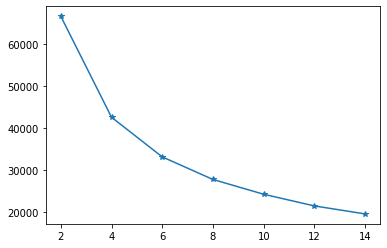

In [21]:
# plot the inertia vs K values
plt.plot(range(2,15,2), inertia_vals, marker='*')
plt.show()

Here, the elbow is somewhere between 4 and 6. Either values can be selected as the optimal $K$.

While being a good heuristic, elbow method sometimes do not always yield the
"obvious" K. In many cases, the error plot can be very smooth and shows no
distinct K. As an alternative, **silhouette score** is commonly used. Silhouette score is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). The silhouette ranges from -1 to 1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters. If most objects have a high value, then the clustering configuration is deemed high quality. If many data points have a low or negative value, then the clustering configuration may have too many or too few clusters. However, the computation of silhouette score is an expensive process and incurs addition overheads. In large datasets, it may not be feasible to compute the score for all objects/samples/records.

[More info on silhouette](https://en.wikipedia.org/wiki/Silhouette_%28clustering%29)

In the underlying clustering problem, a decision will have to be made by choosing between $K = 4$ and $K = 6$. We can use the `silhouette_score` from `sklearn`, which returns mean silhouette score for all samples for both solutions.

In [22]:
from sklearn.metrics import silhouette_score

print(clusters[1])
print("Silhouette score for k=4", silhouette_score(X, clusters[1].predict(X)))

print(clusters[2])
print("Silhouette score for k=6", silhouette_score(X, clusters[2].predict(X)))

KMeans(n_clusters=4, n_jobs=10, random_state=42)
Silhouette score for k=4 0.33091719115444046
KMeans(n_clusters=6, n_jobs=10, random_state=42)
Silhouette score for k=6 0.25399659182558476


`silhouette_score` returns mean silhouette score of 0.33 for $K=4$ and 0.25 for $K=6$. This shows clusters in $K=4$ are more appropriately matched to its own cluster then $K=6$. Therefore, we could choose $K=4$ over $K=6$ on the basis of this score.

Sum of intra-cluster distance: 42564.197151149216
Centroid locations:
[-0.33314101  2.30743581  0.22102952]
[-0.40106113 -0.19147382 -0.89295077]
[1.80312021 0.4098886  0.84130225]
[-0.15468572 -0.37277263  0.79552382]
Cluster membership
1    14526
3    10853
2     4544
0     2156
Name: Cluster_ID, dtype: int64


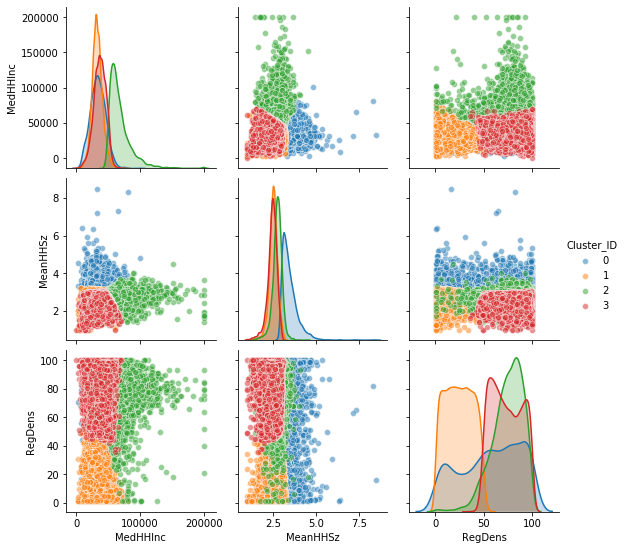

In [23]:
# visualisation of K=4 clustering solution
model = KMeans(n_clusters=4, random_state=rs)
model.fit(X)

# sum of intra-cluster distances
print("Sum of intra-cluster distance:", model.inertia_)

print("Centroid locations:")
for centroid in model.cluster_centers_:
    print(centroid)

y = model.predict(X)
df2['Cluster_ID'] = y

# how many in each
print("Cluster membership")
print(df2['Cluster_ID'].value_counts())

# pairplot
# added alpha value to assist with overlapping points
cluster_g = sns.pairplot(df2, hue='Cluster_ID', plot_kws={'alpha': 0.5})
plt.show()

## End Notes

In these notes, we learned how to build, tune and explore clustering models. We also used visualisation to help us explain the cluster/segment profiles produced by the model. The goal of cluster analysis is to identify distinct groupings of cases across a set of inputs without the presence of target variable. 